<a href="https://colab.research.google.com/github/3morii74/Machine-learning-project/blob/main/MLProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install pandas numpy scikit-learn tensorflow imblearn gradio matplotlib seaborn

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Load data (already in your notebook)
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [32]:
data = data.drop('customerID', axis=1)

In [5]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

In [6]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
label_encoder = LabelEncoder()
for col in binary_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [7]:
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [8]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Save feature names for GUI
feature_names = X.columns.tolist()
with open('/content/drive/MyDrive/Churn_Models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Save scaler for GUI
with open('/content/drive/MyDrive/Churn_Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [11]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7244, 30), y_train shape: (7244,)
X_val shape: (1056, 30), y_val shape: (1056,)
X_test shape: (1057, 30), y_test shape: (1057,)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import os

# Ensure Churn_Models directory exists
os.makedirs('/content/drive/MyDrive/Churn_Models', exist_ok=True)

# Define model architectures
def create_model1(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model2(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model3(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model creators
model_creators = {'FNN': create_model1, 'DNN': create_model2, 'Regularized': create_model3}
histories = {}

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train each model with each optimizer
input_dim = X_train.shape[1]
for model_name, create_model in model_creators.items():
    for opt_name in ['Adam', 'RMSprop', 'SGD']:
        print(f"Training {model_name} with {opt_name}")

        # Create a fresh model instance
        model = create_model(input_dim)

        # Create a fresh optimizer instance
        if opt_name == 'Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        elif opt_name == 'RMSprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        else:  # SGD
            optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

        # Compile the model
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )

        # Store training history
        histories[f"{model_name}_{opt_name}"] = history.history

        # Save the trained model in .keras format
        model.save(f"/content/{model_name}_{opt_name}.keras")

        model_path = f"/content/drive/MyDrive/Churn_Models/{model_name}_{opt_name}.keras"
        model.save(model_path)
        print(f"Saved model to {model_path}")

import pickle
with open('/content/drive/MyDrive/Churn_Models/histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Verify saved models
print("Models saved:")
for file in os.listdir('/content/drive/MyDrive/Churn_Models'):
    if file.endswith('.keras'):
        size = os.path.getsize(f'/content/drive/MyDrive/Churn_Models/{file}') / 1024
        print(f"{file}: {size:.2f} KB")

Training FNN with Adam
Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7449 - loss: 0.5230 - val_accuracy: 0.7292 - val_loss: 0.5179
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7775 - loss: 0.4553 - val_accuracy: 0.7263 - val_loss: 0.5476
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7889 - loss: 0.4391 - val_accuracy: 0.7339 - val_loss: 0.5252
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7950 - loss: 0.4238 - val_accuracy: 0.7462 - val_loss: 0.5060
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8011 - loss: 0.4222 - val_accuracy: 0.7652 - val_loss: 0.4852
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8023 - loss: 0.4166 - val_accuracy: 0.7680 - val_loss: 0.4889
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8112 - loss: 0.4105 - val_accuracy: 0.7377 - val_loss: 0.5466
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8064 

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()

# Define model architectures
def create_model1(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model2(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model3(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model creators
model_creators = {'FNN': create_model1, 'DNN': create_model2, 'Regularized': create_model3}

# Evaluate each model on test set
test_results = {}
for model_name, create_model in model_creators.items():
    for opt_name in ['Adam', 'RMSprop', 'SGD']:
        print(f"Evaluating {model_name} with {opt_name}")

        # Load the saved model
        model = load_model(f"/content/{model_name}_{opt_name}.keras")

        # Predict on test set
        y_pred = (model.predict(X_test) > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        test_results[f"{model_name}_{opt_name}"] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

# Print test results
for model_opt, metrics in test_results.items():
    print(f"\n{model_opt}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

Evaluating FNN with Adam
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluating FNN with RMSprop
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Evaluating FNN with SGD
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Evaluating DNN with Adam
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating DNN with RMSprop
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluating DNN with SGD
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating Regularized with Adam
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating Regularized with RMSprop
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluating Regularized with SGD
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

FNN_Adam:
Accuracy: 0.7692
Precision: 0.5496
Recall: 0.7295
F1 Score: 0.6269

FNN_RMSprop:
Accuracy: 0.7711
Precision: 0.5572
Recall: 0.6762
F1 Score: 0.6109

FNN_SGD:
Accuracy: 0.7711
Precision: 0.5679
Recall: 0.5801
F1 Score: 0.5739

DNN_Adam:
Accuracy: 0.7758
Precision: 0.5643
Recall: 0.6868
F1 Score: 0.6196

DNN_RMSprop:
Accuracy: 0.7597
Precision: 0.5440
Recall: 0.5943
F1 Score: 0.5680

DNN_SGD:
Accuracy: 0.7711
Precision: 0.5534
Recall: 0.7189
F1 Score: 0.6254

Regularized_Adam:
Accuracy: 0.7606
Precision: 0.5372
Recall: 0.7189
F1 Score: 0.6149

Regularized_RMSprop:
Accuracy: 0.7588
Precision: 0.5333
Recall: 0.7402
F1 Score: 0.6200

Regularized_SGD:
Accuracy: 0.7531
Precision: 0.5239
Recall: 0.7794
F1 Score: 0.6266


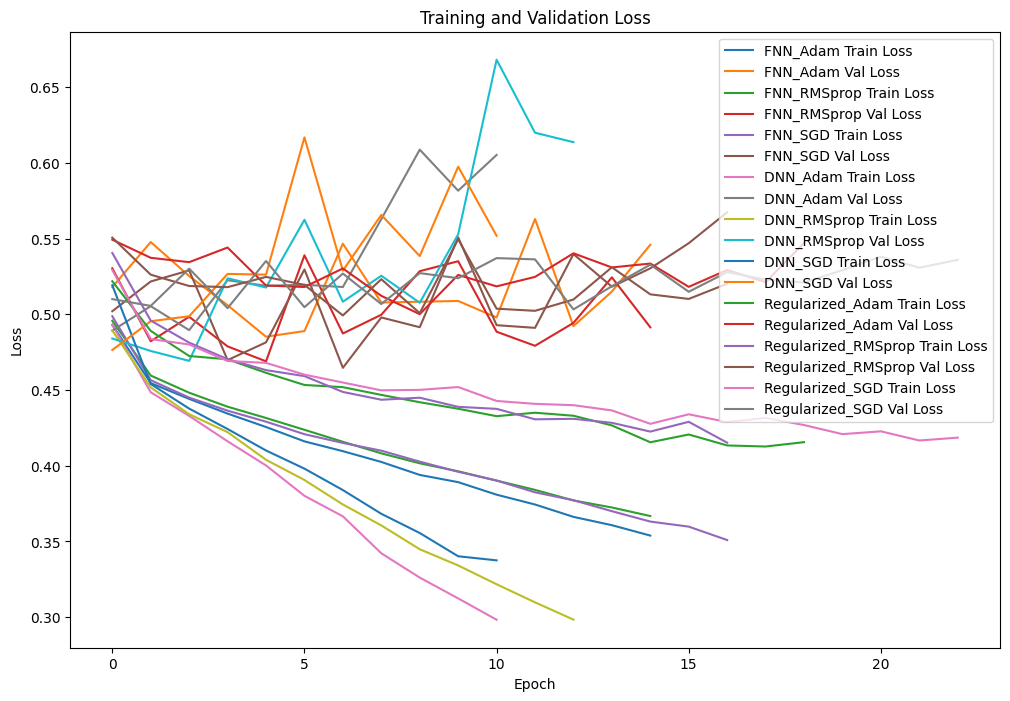

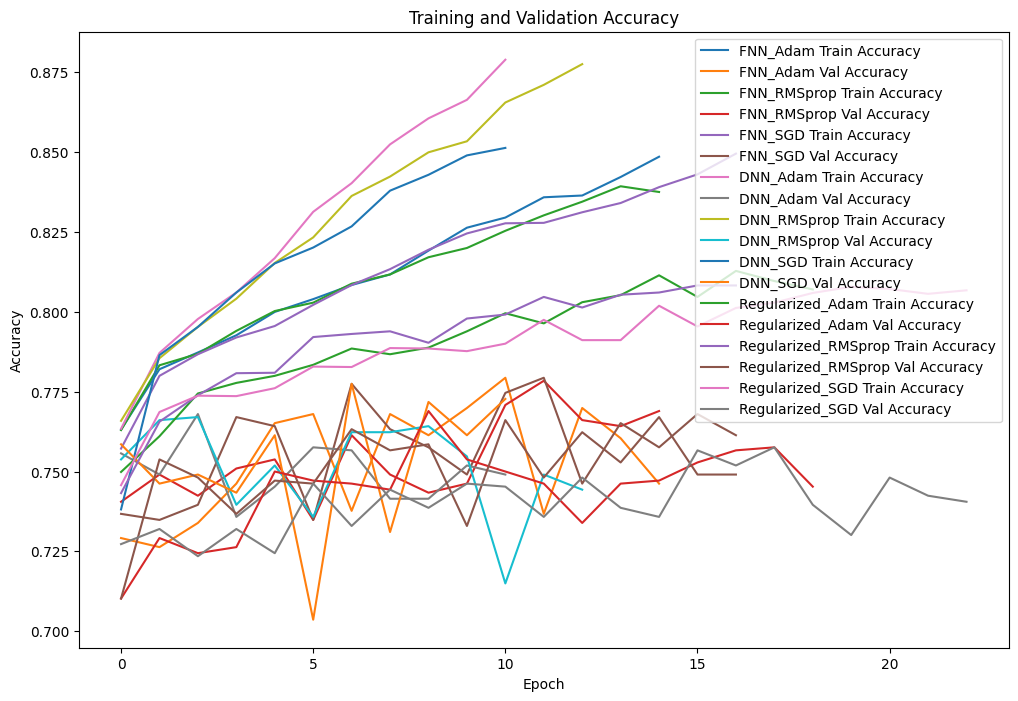

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for model_opt, history in histories.items():
    plt.plot(history['loss'], label=f'{model_opt} Train Loss')
    plt.plot(history['val_loss'], label=f'{model_opt} Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for model_opt, history in histories.items():
    plt.plot(history['accuracy'], label=f'{model_opt} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'{model_opt} Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
import shutil
for file in os.listdir('/content'):
    if file.endswith('.keras'):
        shutil.move(f'/content/{file}', f'/content/drive/MyDrive/Churn_Models/{file}')

In [34]:
import pickle
with open('/content/training_histories.pkl', 'wb') as f:
    pickle.dump(histories, f)
with open('/content/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os
print(os.listdir('/content/drive/MyDrive'))

['DSC_0067.JPG', 'IMG_0042.JPG', 'IMG_0038.JPG', 'DSC_0053.JPG', 'IMG_0048.JPG', 'DSC_0021.JPG', 'شهادات هويدا فاروق.pdf', 'Microsoft_Office_FrontPage_2003_(English)', '5بيكس.pptx', 'Microsoft_Office_FrontPage_2003_(English).rar (Unzipped Files)', 'Previous Certificates_AYA HESHAM IBRAHIM IBRAHIM MOHAMED_1442.pdf', "Mother's passport.pdf", 'C', 'التوكيل (1).pdf', 'التوكيل.pdf', 'COVID vaccinations.pdf', 'Share with CamScanner.zip', 'Untitled document.gdoc', 'Final Project Dr.Pet CS283', 'Untitled video.mp4', 'b56225fb-5cd1-4fce-bad3-32f59abb237e.jpeg', 'IMG_2655.heic', 'IMG_2656.heic', 'CamScanner 05-02-2024 21.07(1).pdf', 'CamScanner 05-02-2024 21.07.pdf', 'gameMini-LAPTOP-G2MQO5VI.rar', 'gameMini-LAPTOP-G2MQO5VI.zip', 'gameMini-LAPTOP-G2MQO5VI', 'DessertsElegants', 'LongGameLevel1.txt', 'LongGameLevel2.txt', 'LongGame.rar', 'LongGame.zip', 'Video.mov', 'react-task', 'Important‼️\n\nMSA 👩\u200d💻\nID   230489\nPassword(student zone)  Aya04hi\nPassword (e learning)  A2496hi\nPassword (l

In [37]:
os.makedirs('/content/drive/MyDrive/Churn_Models', exist_ok=True)
print("Directory created or already exists")

Directory created or already exists


In [40]:
from google.colab import files

# Download all .keras files
for model_name in ['FNN', 'DNN', 'Regularized']:
    for opt_name in ['Adam', 'RMSprop', 'SGD']:
        file_path = f"/content/drive/MyDrive/Churn_Models/{model_name}_{opt_name}.keras"
        print(f"Downloading {file_path}")
        files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
!pip install gradio

In [42]:
import os
print(os.listdir('/content/drive/MyDrive/Churn_Models'))

['feature_names.pkl', 'scaler.pkl', 'FNN_SGD.keras', 'DNN_SGD.keras', 'DNN_Adam.keras', 'DNN_RMSprop.keras', 'Regularized_RMSprop.keras', 'Regularized_SGD.keras', 'FNN_Adam.keras', 'FNN_RMSprop.keras', 'Regularized_Adam.keras']


In [43]:
feature_names = X.columns.tolist()
with open('/content/drive/MyDrive/Churn_Models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

In [44]:
with open('/content/drive/MyDrive/Churn_Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [46]:
import gradio as gr
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check Churn_Models directory
if not os.path.exists('/content/drive/MyDrive/Churn_Models'):
    raise FileNotFoundError("Churn_Models directory not found. Please run the training cell.")

# Load scaler and feature names
try:
    with open('/content/drive/MyDrive/Churn_Models/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('/content/drive/MyDrive/Churn_Models/feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
except FileNotFoundError as e:
    raise FileNotFoundError("Scaler or feature_names file not found. Please re-run preprocessing.")

# Load or compute test_results
test_results = {}
test_results_path = '/content/drive/MyDrive/Churn_Models/test_results.pkl'
if os.path.exists(test_results_path):
    with open(test_results_path, 'rb') as f:
        test_results = pickle.load(f)
else:
    def compute_test_results():
        global test_results
        for model_name in ['FNN', 'DNN', 'Regularized']:
            for opt_name in ['Adam', 'RMSprop', 'SGD']:
                model_path = f"/content/drive/MyDrive/Churn_Models/{model_name}_{opt_name}.keras"
                if not os.path.exists(model_path):
                    print(f"Skipping {model_name}_{opt_name}: Model file not found")
                    continue
                print(f"Computing metrics for {model_name} with {opt_name}")
                model = load_model(model_path)
                y_pred = (model.predict(X_test) > 0.5).astype(int)
                test_results[f"{model_name}_{opt_name}"] = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred),
                    'recall': recall_score(y_test, y_pred),
                    'f1': f1_score(y_test, y_pred)
                }
    try:
        compute_test_results()
        with open(test_results_path, 'wb') as f:
            pickle.dump(test_results, f)
    except NameError as e:
        raise NameError("X_test or y_test not defined. Please re-run preprocessing.")

# Function to map raw inputs to one-hot encoded features
def map_inputs_to_features(
    tenure, MonthlyCharges, TotalCharges, gender, Partner, Dependents, PhoneService,
    MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection,
    TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
):
    # Initialize feature dictionary with zeros
    input_dict = {f: 0 for f in feature_names}

    # Numerical features
    input_dict['tenure'] = tenure
    input_dict['MonthlyCharges'] = MonthlyCharges
    input_dict['TotalCharges'] = TotalCharges

    # Binary features
    input_dict['gender_Male'] = 1 if gender == 'Male' else 0
    input_dict['Partner_Yes'] = 1 if Partner == 'Yes' else 0
    input_dict['Dependents_Yes'] = 1 if Dependents == 'Yes' else 0
    input_dict['PhoneService_Yes'] = 1 if PhoneService == 'Yes' else 0
    input_dict['PaperlessBilling_Yes'] = 1 if PaperlessBilling == 'Yes' else 0

    # Categorical features
    input_dict['MultipleLines_Yes'] = 1 if MultipleLines == 'Yes' else 0
    input_dict['MultipleLines_No_phone_service'] = 1 if MultipleLines == 'No phone service' else 0

    input_dict['InternetService_Fiber_optic'] = 1 if InternetService == 'Fiber optic' else 0
    input_dict['InternetService_No'] = 1 if InternetService == 'No' else 0

    input_dict['OnlineSecurity_Yes'] = 1 if OnlineSecurity == 'Yes' else 0
    input_dict['OnlineSecurity_No_internet_service'] = 1 if OnlineSecurity == 'No internet service' else 0

    input_dict['OnlineBackup_Yes'] = 1 if OnlineBackup == 'Yes' else 0
    input_dict['OnlineBackup_No_internet_service'] = 1 if OnlineBackup == 'No internet service' else 0

    input_dict['DeviceProtection_Yes'] = 1 if DeviceProtection == 'Yes' else 0
    input_dict['DeviceProtection_No_internet_service'] = 1 if DeviceProtection == 'No internet service' else 0

    input_dict['TechSupport_Yes'] = 1 if TechSupport == 'Yes' else 0
    input_dict['TechSupport_No_internet_service'] = 1 if TechSupport == 'No internet service' else 0

    input_dict['StreamingTV_Yes'] = 1 if StreamingTV == 'Yes' else 0
    input_dict['StreamingTV_No_internet_service'] = 1 if StreamingTV == 'No internet service' else 0

    input_dict['StreamingMovies_Yes'] = 1 if StreamingMovies == 'Yes' else 0
    input_dict['StreamingMovies_No_internet_service'] = 1 if StreamingMovies == 'No internet service' else 0

    input_dict['Contract_One_year'] = 1 if Contract == 'One year' else 0
    input_dict['Contract_Two_year'] = 1 if Contract == 'Two year' else 0

    input_dict['PaymentMethod_Credit_card_(automatic)'] = 1 if PaymentMethod == 'Credit card (automatic)' else 0
    input_dict['PaymentMethod_Electronic_check'] = 1 if PaymentMethod == 'Electronic check' else 0
    input_dict['PaymentMethod_Mailed_check'] = 1 if PaymentMethod == 'Mailed check' else 0

    # Convert to DataFrame
    input_df = pd.DataFrame([input_dict], columns=feature_names)

    # Scale numerical features
    input_array = input_df.values
    input_array[:, :3] = scaler.transform(input_array[:, :3])

    return input_array

# Function to predict churn
def predict_churn(
    model_name, optimizer,
    tenure, MonthlyCharges, TotalCharges, gender, Partner, Dependents, PhoneService,
    MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection,
    TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
):
    try:
        # Load model
        model_path = f"/content/drive/MyDrive/Churn_Models/{model_name}_{optimizer}.keras"
        if not os.path.exists(model_path):
            return f"Model file not found: {model_path}. Please ensure the training cell has been run."

        model = load_model(model_path)

        # Map inputs to features
        input_array = map_inputs_to_features(
            tenure, MonthlyCharges, TotalCharges, gender, Partner, Dependents, PhoneService,
            MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection,
            TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
        )

        # Predict
        prediction = model.predict(input_array)
        prob = prediction[0][0]
        churn = "Churn" if prob > 0.5 else "No Churn"

        # Get test metrics
        metrics = test_results.get(f"{model_name}_{optimizer}", {})
        metrics_str = (f"Accuracy: {metrics.get('accuracy', 'N/A'):.4f}\n"
                      f"Precision: {metrics.get('precision', 'N/A'):.4f}\n"
                      f"Recall: {metrics.get('recall', 'N/A'):.4f}\n"
                      f"F1 Score: {metrics.get('f1', 'N/A'):.4f}")

        return (f"Prediction: {churn}\n"
                f"Confidence: {prob:.4f}\n\n"
                f"Test Metrics:\n{metrics_str}")
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Telco Customer Churn Prediction")

    with gr.Row():
        model_choice = gr.Dropdown(choices=['FNN', 'DNN', 'Regularized'], label="Select Model")
        optimizer_choice = gr.Dropdown(choices=['Adam', 'RMSprop', 'SGD'], label="Select Optimizer")

    gr.Markdown("### Customer Data")

    with gr.Row():
        tenure = gr.Slider(0, 72, label="Tenure (months)", step=1)
        MonthlyCharges = gr.Slider(0, 200, label="Monthly Charges ($)", step=0.1)
        TotalCharges = gr.Slider(0, 10000, label="Total Charges ($)", step=1)

    with gr.Row():
        gender = gr.Dropdown(choices=['Male', 'Female'], label="Gender")
        Partner = gr.Dropdown(choices=['Yes', 'No'], label="Partner")
        Dependents = gr.Dropdown(choices=['Yes', 'No'], label="Dependents")
        PhoneService = gr.Dropdown(choices=['Yes', 'No'], label="Phone Service")
        PaperlessBilling = gr.Dropdown(choices=['Yes', 'No'], label="Paperless Billing")

    with gr.Row():
        MultipleLines = gr.Dropdown(choices=['No', 'Yes', 'No phone service'], label="Multiple Lines")
        InternetService = gr.Dropdown(choices=['DSL', 'Fiber optic', 'No'], label="Internet Service")
        Contract = gr.Dropdown(choices=['Month-to-month', 'One year', 'Two year'], label="Contract")
        PaymentMethod = gr.Dropdown(choices=['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check'], label="Payment Method")

    with gr.Row():
        OnlineSecurity = gr.Dropdown(choices=['No', 'Yes', 'No internet service'], label="Online Security")
        OnlineBackup = gr.Dropdown(choices=['No', 'Yes', 'No internet service'], label="Online Backup")
        DeviceProtection = gr.Dropdown(choices=['No', 'Yes', 'No internet service'], label="Device Protection")
        TechSupport = gr.Dropdown(choices=['No', 'Yes', 'No internet service'], label="Tech Support")

    with gr.Row():
        StreamingTV = gr.Dropdown(choices=['No', 'Yes', 'No internet service'], label="Streaming TV")
        StreamingMovies = gr.Dropdown(choices=['No', 'Yes', 'No internet service'], label="Streaming Movies")

    predict_button = gr.Button("Predict")
    output = gr.Textbox(label="Prediction and Metrics")

    predict_button.click(
        fn=predict_churn,
        inputs=[
            model_choice, optimizer_choice,
            tenure, MonthlyCharges, TotalCharges, gender, Partner, Dependents, PhoneService,
            MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection,
            TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
        ],
        outputs=output
    )

# Launch the interface
demo.launch(share=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cdff964b66dfea78ab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
